In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor as rf
import xgboost as xgb
import optuna
# import random
# np.random.seed(1234)
# random.seed(1234)
import warnings
warnings.filterwarnings('ignore')

# data load
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/sample_submission.csv')

In [2]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [4]:
train_df['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [5]:
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True) # sort : 열을 기준으로 정렬(abc순)
all_df


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [6]:
all_df['SalePrice']

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
2914         NaN
2915         NaN
2916         NaN
2917         NaN
2918         NaN
Name: SalePrice, Length: 2919, dtype: float64

In [7]:
from sklearn.preprocessing import LabelEncoder
categories = all_df.columns[all_df.dtypes=='object']
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [8]:
all_df['Alley'].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

In [9]:
for cat in categories:
    le = LabelEncoder()
    print(cat)
    all_df[cat].fillna('missing', inplace=True)
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype('category')

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [10]:
train_df_le = all_df[all_df['SalePrice'].notnull()]
test_df_le = all_df[all_df['SalePrice'].isnull()]

In [11]:
folds = 3
kf = KFold(n_splits=folds)

In [12]:
lgbm_params = {
    'objective':'regression',
    'random_seed':1234
}

In [13]:
train_X = train_df_le.drop(['SalePrice','Id'], axis=1)
train_Y = train_df_le['SalePrice']

In [14]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    model_lgb = lgb.train(params=lgbm_params,
                          train_set=lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                          )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print('rmse:',tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred
    


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2964
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 179726.031860
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 1.57807e+09
[20]	valid_0's l2: 7.38516e+08
[30]	valid_0's l2: 5.93255e+08
[40]	valid_0's l2: 5.6061e+08
[50]	valid_0's l2: 5.48225e+08
[60]	valid_0's l2: 5.46182e+08
[70]	valid_0's l2: 5.51735e+08
Early stopping, best iteration is:
[55]	valid_0's l2: 5.45194e+08
rmse: 0.12719558859476138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2985
[LightGBM] [Info] Nu

In [15]:
np.mean(rmses)

0.1359164479233318

<AxesSubplot:>

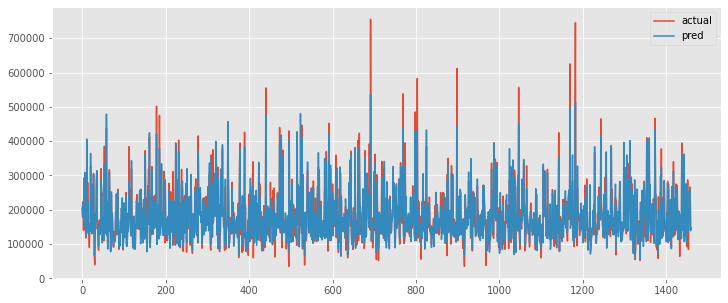

In [16]:
actual_pred_df = pd.DataFrame({'actual':train_Y,
                               'pred':oof})
actual_pred_df.plot(figsize=(12,5))

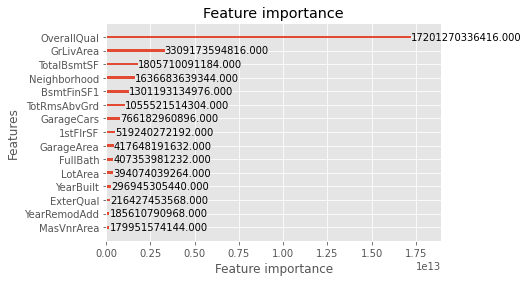

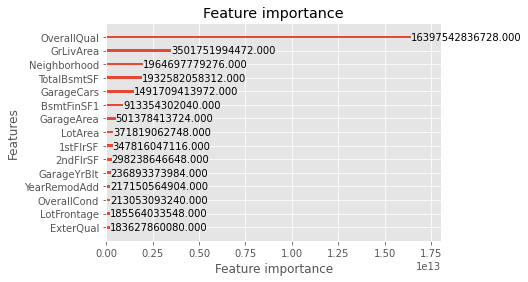

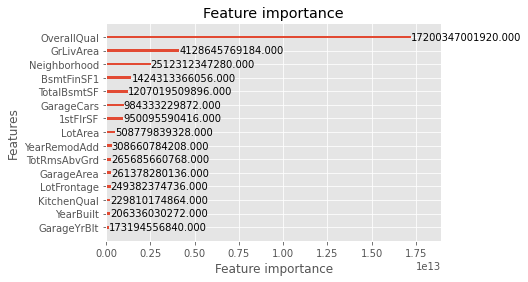

In [17]:
for model in models:
    lgb.plot_importance(model, importance_type='gain', max_num_features=15)

In [18]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:ylabel='Frequency'>

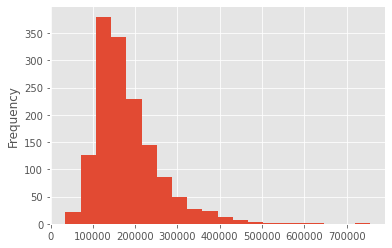

In [19]:
train_df['SalePrice'].plot.hist(bins=20)

<AxesSubplot:ylabel='Frequency'>

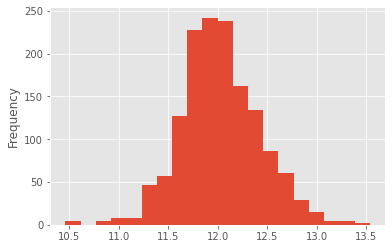

In [20]:
np.log(train_df['SalePrice']).plot.hist(bins=20)

In [21]:
pd.options.mode.chained_assignment = None
train_df_le['SalePrice_log'] = np.log(train_df_le['SalePrice'])

In [22]:
train_X = train_df_le.drop(['SalePrice','SalePrice_log','Id'], axis=1)
train_Y = train_df_le['SalePrice_log']

In [23]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    model_lgb = lgb.train(params=lgbm_params,
                          train_set=lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                          )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print('rmse:',tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred
    


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2964
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 12.017607
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0436707
[20]	valid_0's l2: 0.0219638
[30]	valid_0's l2: 0.0178863
[40]	valid_0's l2: 0.0168272
[50]	valid_0's l2: 0.0165421
[60]	valid_0's l2: 0.0164067
[70]	valid_0's l2: 0.0163235
[80]	valid_0's l2: 0.0162611
[90]	valid_0's l2: 0.0162673
[100]	valid_0's l2: 0.0163207
Did not meet early stopping. Best iteration is:
[81]	valid_0's l2: 0.0162538
rmse: 0.12749050377720023
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_col_wise=tr

In [24]:
np.mean(rmses)

0.13274830975285581

In [25]:
all_df = pd.concat([train_df,test_df], sort=False).reset_index(drop=True)

#### Class 분류 항목의 값을 숫자로 변환

In [26]:
cl_list = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC']
for col in all_df[cl_list].columns:
    all_df[col] = all_df[col].fillna('NA')
    all_df[col] = all_df[col].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0})
    all_df[col].astype('int')

In [27]:
categories = all_df.columns[all_df.dtypes=='object']
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical',
       'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')


In [28]:
all_df.isnull().sum().sort_values(ascending=False).head(40)

MiscFeature      2814
Alley            2721
Fence            2348
SalePrice        1459
LotFrontage       486
GarageYrBlt       159
GarageFinish      159
GarageType        157
BsmtExposure       82
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
BsmtFullBath        2
Functional          2
BsmtHalfBath        2
Utilities           2
Exterior2nd         1
Electrical          1
BsmtUnfSF           1
TotalBsmtSF         1
GarageCars          1
GarageArea          1
BsmtFinSF2          1
SaleType            1
Exterior1st         1
BsmtFinSF1          1
TotRmsAbvGrd        0
KitchenQual         0
Fireplaces          0
FireplaceQu         0
KitchenAbvGr        0
BedroomAbvGr        0
SaleCondition       0
EnclosedPorch       0
YrSold              0
OpenPorchSF         0
MiscVal             0
PoolQC              0
dtype: int64

In [29]:
all_df['LotArea'].value_counts()

9600     44
7200     43
6000     34
9000     29
10800    25
         ..
15498     1
9439      1
7406      1
3013      1
10441     1
Name: LotArea, Length: 1951, dtype: int64

In [30]:
HighFacility_col = ['PoolQC', 'MiscFeature','Alley']
for col in HighFacility_col:
    if all_df[col].dtype == 'object':
        if len(all_df[all_df[col].isnull()]) > 0:
            all_df.loc[all_df[col].notnull(), col] = 1
            all_df.loc[all_df[col].isnull(), col] = 0

In [31]:
all_df.PoolQC.value_counts()

0    2909
5       4
4       4
2       2
Name: PoolQC, dtype: int64

In [32]:
all_df['hasHighFacility'] = all_df['PoolQC'] + all_df['MiscFeature'] + all_df['Alley']
all_df['hasHighFacility'] = all_df['hasHighFacility'].astype(int)

In [33]:
all_df['hasHighFacility'].value_counts()

0    2615
1     286
2       9
5       4
4       4
3       1
Name: hasHighFacility, dtype: int64

In [34]:
all_df = all_df.drop(['PoolQC','MiscFeature','Alley'], axis=1)

In [35]:
all_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
ExterQual,2919.0,3.396711,0.580293,2.0,3.0,3.0,4.0,5.0


In [36]:
train_df_num = train_df.select_dtypes(include=[np.number]) # 특정 dtype의 column들만 추출

In [37]:
nonratio_features = ['Id','MSSubClass','OverallQual','YearBuilt','YearRemodAdd','MoSold','YrSold']

In [38]:
num_features = sorted(list(set(train_df_num) - set(nonratio_features)))
num_features


['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'OverallCond',
 'PoolArea',
 'SalePrice',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF']

In [39]:
train_df_num_rs = train_df_num[num_features] # 비례척도인 features만 추출

In [40]:
for col in num_features:
    if train_df_num_rs.describe()[col]['75%'] == 0:
        print(col, len(train_df_num_rs[train_df_num_rs[col]==0]))

3SsnPorch 1436
BsmtFinSF2 1293
BsmtHalfBath 1378
EnclosedPorch 1252
LowQualFinSF 1434
MiscVal 1408
PoolArea 1453
ScreenPorch 1344


In [41]:
for col in num_features:
    if train_df_num_rs[col].nunique() < 15:
        print(col, train_df_num_rs[col].nunique())

BedroomAbvGr 8
BsmtFullBath 4
BsmtHalfBath 3
Fireplaces 4
FullBath 4
GarageCars 5
HalfBath 3
KitchenAbvGr 4
OverallCond 9
PoolArea 8
TotRmsAbvGrd 12


In [42]:
for col in num_features:
    tmp_df = train_df_num_rs[(train_df_num_rs[col] > train_df_num_rs[col].mean() + train_df_num_rs[col].std()*3)|
                             (train_df_num_rs[col] < train_df_num_rs[col].mean() - train_df_num_rs[col].std()*3)]
    print(col, len(tmp_df))

1stFlrSF 12
2ndFlrSF 4
3SsnPorch 23
BedroomAbvGr 14
BsmtFinSF1 6
BsmtFinSF2 50
BsmtFullBath 16
BsmtHalfBath 82
BsmtUnfSF 11
EnclosedPorch 51
Fireplaces 5
FullBath 0
GarageArea 7
GarageCars 0
GarageYrBlt 1
GrLivArea 16
HalfBath 12
KitchenAbvGr 68
LotArea 13
LotFrontage 12
LowQualFinSF 20
MasVnrArea 32
MiscVal 8
OpenPorchSF 27
OverallCond 28
PoolArea 7
SalePrice 22
ScreenPorch 55
TotRmsAbvGrd 12
TotalBsmtSF 10
WoodDeckSF 22


<AxesSubplot:xlabel='BsmtFinSF1', ylabel='SalePrice'>

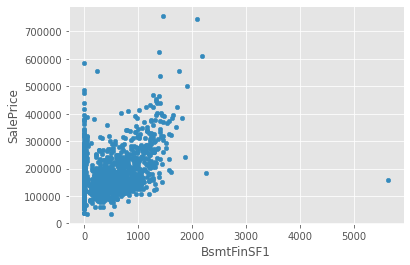

In [43]:
all_df.plot.scatter(x='BsmtFinSF1', y='SalePrice')

In [44]:
all_df[all_df['BsmtFinSF1'] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,4


<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

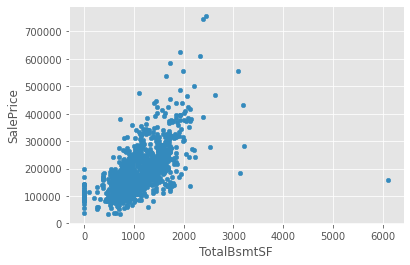

In [45]:
all_df.plot.scatter(x='TotalBsmtSF', y='SalePrice')

In [46]:
all_df[all_df['TotalBsmtSF'] > 6000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,4


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

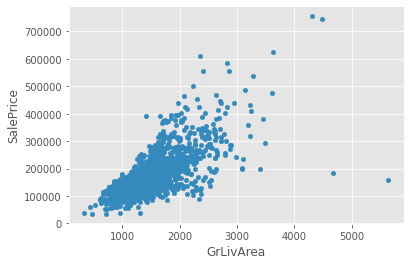

In [47]:
all_df.plot.scatter(x='GrLivArea', y='SalePrice')

In [48]:
all_df[all_df['GrLivArea'] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,4
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

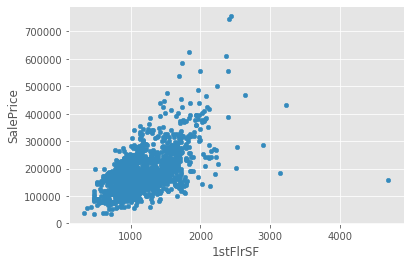

In [49]:
all_df.plot.scatter(x='1stFlrSF', y='SalePrice')

In [50]:
all_df[all_df['1stFlrSF'] > 4000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,4
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


In [51]:
all_df = all_df[(all_df['BsmtFinSF1'] < 2000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['TotalBsmtSF'] < 3000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['GrLivArea'] < 4500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['1stFlrSF'] < 2500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['LotArea'] < 100000) | (all_df['SalePrice'].isnull())]

In [52]:
categories = categories.drop(['MiscFeature','Alley'])

In [53]:
for cat in categories:
    le = LabelEncoder()
    print(cat)
    
    all_df[cat].fillna('missing', inplace=True)
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype('category')

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
Foundation
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
CentralAir
Electrical
Functional
GarageType
GarageFinish
PavedDrive
Fence
SaleType
SaleCondition


In [54]:
train_df_le = all_df[all_df['SalePrice'].notnull()]
test_df_le = all_df[all_df['SalePrice'].isnull()]

train_df_le['SalePrice_log'] = np.log(train_df_le['SalePrice'])



In [55]:
train_X = train_df_le.drop(['SalePrice','SalePrice_log','Id'], axis=1)
train_Y = train_df_le['SalePrice_log']
train_X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,hasHighFacility
0,60,3,65.0,8450,1,3,3,0,4,0,...,0,0,0,4,0,2,2008,8,4,0
1,20,3,80.0,9600,1,3,3,0,2,0,...,0,0,0,4,0,5,2007,8,4,0
2,60,3,68.0,11250,1,0,3,0,4,0,...,0,0,0,4,0,9,2008,8,4,0
3,70,3,60.0,9550,1,0,3,0,0,0,...,0,0,0,4,0,2,2006,8,0,0
4,60,3,84.0,14260,1,0,3,0,2,0,...,0,0,0,4,0,12,2008,8,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,3,3,0,4,0,...,0,0,0,4,0,8,2007,8,4,0
1456,20,3,85.0,13175,1,3,3,0,4,0,...,0,0,0,2,0,2,2010,8,4,0
1457,70,3,66.0,9042,1,3,3,0,4,0,...,0,0,0,0,2500,5,2010,8,4,1
1458,20,3,68.0,9717,1,3,3,0,4,0,...,0,0,0,4,0,4,2010,8,4,0


In [56]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    model_lgb = lgb.train(params=lgbm_params,
                          train_set=lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                          )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print('rmse:',tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2949
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 72
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0426416
[20]	valid_0's l2: 0.0215948
[30]	valid_0's l2: 0.0173646
[40]	valid_0's l2: 0.0162361
[50]	valid_0's l2: 0.0160357
[60]	valid_0's l2: 0.0160585
[70]	valid_0's l2: 0.0161775
Early stopping, best iteration is:
[50]	valid_0's l2: 0.0160357
rmse: 0.12663211754818754
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2944
[LightGBM] [Info] Number of data points

In [57]:
np.mean(rmses)

0.12844098320171557

In [58]:
all_df[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']].describe()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,2904.000000,2904.000000,2745.000000,2904.000000
mean,1971.234504,1984.217975,1978.061202,2007.792011
std,30.319059,20.907346,25.600996,1.316366
min,1872.000000,1950.000000,1895.000000,2006.000000
25%,1953.000000,1965.000000,1960.000000,2007.000000
50%,1973.000000,1993.000000,1979.000000,2008.000000
75%,2001.000000,2004.000000,2002.000000,2009.000000
max,2010.000000,2010.000000,2207.000000,2010.000000


In [59]:
all_df['Age'] = all_df['YrSold'] - all_df['YearBuilt']

In [60]:
train_df_le = all_df[all_df['SalePrice'].notnull()]
test_df_le = all_df[all_df['SalePrice'].isnull()]

train_df_le['SalePrice_log'] = np.log(train_df_le['SalePrice'])
train_X = train_df_le.drop(['SalePrice','SalePrice_log','Id'], axis=1)
train_Y = train_df_le['SalePrice_log']


models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    model_lgb = lgb.train(params=lgbm_params,
                          train_set=lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                          )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print('rmse:',tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3046
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 73
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0425389
[20]	valid_0's l2: 0.0219178
[30]	valid_0's l2: 0.0174383
[40]	valid_0's l2: 0.0164377
[50]	valid_0's l2: 0.0164095
[60]	valid_0's l2: 0.016341
[70]	valid_0's l2: 0.0164372
Early stopping, best iteration is:
[55]	valid_0's l2: 0.0163011
rmse: 0.12767572434430746
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3038
[LightGBM] [Info] Number of data points 

In [61]:
np.mean(rmses)

0.12941651785513233

In [62]:
all_df['TotalSF'] = all_df['TotalBsmtSF'] + all_df['1stFlrSF'] + all_df['2ndFlrSF']
all_df['Total_Bathrooms'] = all_df['FullBath'] + all_df['HalfBath'] + all_df['BsmtFullBath'] + all_df['BsmtHalfBath']

In [63]:
all_df['Total_PorchSF'] = all_df['WoodDeckSF'] + all_df['OpenPorchSF'] + all_df['EnclosedPorch'] + all_df['3SsnPorch'] + all_df['ScreenPorch']

In [64]:
all_df['hasPorch'] = all_df['Total_PorchSF'].apply(lambda x:1 if x > 0 else 0)
all_df = all_df.drop('Total_PorchSF', axis=1)

In [65]:
train_df_le = all_df[all_df['SalePrice'].notnull()]
test_df_le = all_df[all_df['SalePrice'].isnull()]

train_df_le['SalePrice_log'] = np.log(train_df_le['SalePrice'])
train_X = train_df_le.drop(['SalePrice','SalePrice_log','Id'], axis=1)
train_Y = train_df_le['SalePrice_log']


models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    model_lgb = lgb.train(params=lgbm_params,
                          train_set=lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                          )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print('rmse:',tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3310
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 76
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0385079
[20]	valid_0's l2: 0.0193005
[30]	valid_0's l2: 0.0155222
[40]	valid_0's l2: 0.0148029
[50]	valid_0's l2: 0.0145988
[60]	valid_0's l2: 0.0146073
[70]	valid_0's l2: 0.0147846
Early stopping, best iteration is:
[58]	valid_0's l2: 0.0145745
rmse: 0.12072493696968234
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM

In [66]:
np.mean(rmses)

0.12657437406328625

In [67]:
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2, random_state=1234, shuffle=False, stratify=None)

In [68]:
def objective(trial):
    params = {
        'objetive':'regression',
        'random_seed':1234,
        'learning_rate':0.05,
        'n_estimators':1000,
        'num_leaves':trial.suggest_int('num_leaves', 4, 64),
        'max_bin':trial.suggest_int('max_bin', 50, 200),
        'bagging_fraction':trial.suggest_uniform('bagging_fraction', 0.4, 0.9),
        'bagging_freq':trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction':trial.suggest_uniform('feature_fraction', 0.4, 0.9),
        'min_data_in_leaf':trial.suggest_int('min_data_in_leaf', 2, 16),
        'min_sum_hessian_in_leaf':trial.suggest_int('min_sum_hessian_in_leaf', 1, 10),
    }
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    model_lgb = lgb.train(params,
                          train_set=lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                          )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    return score

In [69]:
# study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
# study.optimize(objective, n_trials=50)
# study.best_params

In [70]:
lgbm_params = {
    'objective':'regression',
    'random_seed':1234,
    'learning_rate':0.05,
    'n_estimators':1000,
    'num_leaves': 33,
    'max_bin': 125,
    'bagging_fraction': 0.7197362581993618,
    'bagging_freq': 4,
    'feature_fraction': 0.4684501358427995,
    'min_data_in_leaf': 14,
    'min_sum_hessian_in_leaf': 2
}

In [71]:
train_df_le = all_df[all_df['SalePrice'].notnull()]
test_df_le = all_df[all_df['SalePrice'].isnull()]

train_df_le['SalePrice_log'] = np.log(train_df_le['SalePrice'])
train_X = train_df_le.drop(['SalePrice','SalePrice_log','Id'], axis=1)
train_Y = train_df_le['SalePrice_log']


models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    model_lgb = lgb.train(params=lgbm_params,
                          train_set=lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                          )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print('rmse:',tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2374
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 77
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0729955
[20]	valid_0's l2: 0.0387712
[30]	valid_0's l2: 0.0256207
[40]	valid_0's l2: 0.0194388
[50]	valid_0's l2: 0.0165216
[60]	valid_0's l2: 0.0151431
[70]	valid_0's l2: 0.0145348
[80]	valid_0's l2: 0.0141475
[90]	valid_0's l2: 0.0140342
[100]	valid_0's l2: 0.013821
[110]	valid_0's l2: 0.0137027
[120]	valid_0's l2: 0.0136203
[130]	valid_0's l2: 0.0135632
[140]	valid_0's l2: 0.0135647
[150]	valid_0's l2: 0.0134996
[160]	valid_0's l2: 0.0135136
[170]	valid_0's l2: 0.0134952
[180]	valid_0's l2: 0.0135345
[

In [72]:
np.mean(rmses)

0.12122823028253259

In [73]:
test_X = test_df_le.drop(['SalePrice','Id'], axis=1)

In [74]:
preds = []

for model in models:
    pred = model.predict(test_X)
    preds.append(pred) 

In [75]:
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)

In [76]:
preds_exp = np.exp(preds_mean)

In [77]:
len(preds_exp)

1459

In [78]:
submission['SalePrice'] = preds_exp

In [79]:
# submission.to_csv('./submit/minsung_houseprices_submit01.csv', index=False)

In [80]:
hasnan_cat = []
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != 'SalePrice'):
        print(col, tmp_null_count)
        hasnan_cat.append(col)

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


In [81]:
all_df[hasnan_cat].describe().T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,2425.0,69.071340,22.662001,21.0,59.0,68.0,80.0,313.0
MasVnrArea,2882.0,101.191187,177.804595,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2903.0,434.926628,440.128728,0.0,0.0,365.0,728.5,4010.0
BsmtFinSF2,2903.0,49.016879,168.444473,0.0,0.0,0.0,0.0,1526.0
BsmtUnfSF,2903.0,559.850499,438.438879,0.0,220.0,467.0,802.5,2336.0
TotalBsmtSF,2903.0,1043.794006,420.008348,0.0,791.5,988.0,1296.0,5095.0
BsmtFullBath,2902.0,0.426258,0.522410,0.0,0.0,0.0,1.0,3.0
BsmtHalfBath,2902.0,0.061337,0.245667,0.0,0.0,0.0,0.0,2.0
GarageYrBlt,2745.0,1978.061202,25.600996,1895.0,1960.0,1979.0,2002.0,2207.0
GarageCars,2903.0,1.763348,0.761410,0.0,1.0,2.0,2.0,5.0


In [82]:
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != 'SalePrice'):
        print(col, tmp_null_count)
        all_df[col] = all_df[col].fillna(all_df[col].median())

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


In [83]:
train_df_le = all_df[all_df['SalePrice'].notnull()]
test_df_le = all_df[all_df['SalePrice'].isnull()]
train_df_le['SalePrice_log'] = np.log(train_df_le['SalePrice'])

train_df_le.to_csv('data/train_df_test.csv',index=False)
test_df_le.to_csv('data/test_df_test.csv',index=False)

In [84]:
train_X = train_df_le.drop(['SalePrice','SalePrice_log','Id'], axis=1)
train_Y = train_df_le['SalePrice_log']

In [85]:
folds = 3
kf = KFold(n_splits=folds)

In [86]:
models_rf = []
rmses_rf = []
oof_rf = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    model_rf = rf(n_estimators=50,
                  random_state=1234,
                  )
    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_valid)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print('rmse:',tmp_rmse)
    
    models_rf.append(model_rf)
    rmses_rf.append(tmp_rmse)
    oof_rf[val_index] = y_pred

rmse: 0.13858648742348345
rmse: 0.14255184121173167
rmse: 0.13025642649095237


In [87]:
np.mean(rmses_rf)

0.13713158504205583

In [88]:
test_X = test_df_le.drop(['SalePrice','Id'], axis=1)

In [89]:
preds_rf = []
for model in models_rf:
    pred = model.predict(test_X)
    preds_rf.append(pred)

In [90]:
preds_array_rf = np.array(preds_rf)
preds_mean_rf = np.mean(preds_array_rf, axis=0)
preds_exp_rf = np.exp(preds_mean_rf)
submission['SalePrice'] = preds_exp_rf

In [91]:
# submission.to_csv('./submit/minsung_houseprices_submit02.csv', index=False)

In [92]:
categories = train_X.columns[train_X.dtypes=='category']

In [93]:
for col in categories:
    train_X[col] = train_X[col].astype(int)
    test_X[col] = test_X[col].astype(int)

In [94]:
xgb_params = {
    'learning_rate':0.05,
    'seed':1234,
    'max_depth':6,
    'colsample_bytree':0.330432640328732,
    'sublsample':0.7158427239902707
}

In [95]:
models_xgb = []
rmses_xgb = []
oof_xgb = np.zeros(len(train_X))
for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_eval = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(xgb_train,'train'), (xgb_eval,'eval')]
    model_xgb = xgb.train(xgb_params,
                          xgb_train,
                          evals=evals,
                          num_boost_round=1000,
                          early_stopping_rounds=20,
                          verbose_eval=20,
                          )
    y_pred = model_xgb.predict(xgb_eval)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print('tmp_rmse:',tmp_rmse)
    models_xgb.append(model_xgb)
    rmses_xgb.append(tmp_rmse)
    oof_xgb[val_index] = y_pred

[15:11:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "sublsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:10.94265	eval-rmse:10.96235
[20]	train-rmse:3.93996	eval-rmse:3.95625
[40]	train-rmse:1.42940	eval-rmse:1.44093
[60]	train-rmse:0.53090	eval-rmse:0.54274
[80]	train-rmse:0.21353	eval-rmse:0.23411
[100]	train-rmse:0.10558	eval-rmse:0.14416
[120]	train-rmse:0.07019	eval-rmse:0.12287
[140]	train-rmse:0.05719	eval-rmse:0.11730
[160]	train-rmse:0.04997	eval-rmse:0.11525
[180]	train-rmse:0.04428	eval-rmse:0.11431
[200]	train-rmse:0.03970	eval-rmse:0.11367
[220]	train-rmse:0.03552	eval-rmse:0.11357
[240]	train-rmse:0.03266	eval-rmse:0.11

In [96]:
np.mean(rmses_xgb)

0.12018032584896021

In [97]:
xgb_test = xgb.DMatrix(test_X)
preds_xgb = []
for model in models_xgb:
    pred = model.predict(xgb_test)
    preds_xgb.append(pred)

In [98]:
preds_array_xgb = np.array(preds_xgb)
preds_mean_xgb = np.mean(preds_array_xgb, axis=0)
preds_exp_xgb = np.exp(preds_mean_xgb)
submission['SalePrice'] = preds_exp_xgb

In [99]:
# submission.to_csv('./submit/minsung_houseprices_submit03.csv', index=False)

In [100]:
preds_ans = preds_exp_xgb * 0.5 + preds_exp * 0.5
submission['SalePrice'] = preds_ans

In [101]:
# submission.to_csv('./submit/minsung_houseprices_submit04.csv', index=False)